# Motivation and Introduction
This is another reproduction work on the paper High-accuracy Decoding of Complex Visual Scenes from Neuronal Calcium Responses by Randall J. Ellis and Michael Michaelides.

The original dataset is Allen Brain Observary (ABO), but here we are using Ecephys Project dataset, since it has a higher resolution and more information.

In [6]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import xarray as xr


# Data Preprocessing

In [3]:

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

data_directory = 'H:\\allenSDKdata' # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path, timeout=9999999999999999)

sessions = cache.get_session_table()
print('Total number of sessions: ' + str(len(sessions)))
sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


In [4]:

import warnings
# supress the so-annoying warnings
warnings.filterwarnings("ignore", r".*some overlapping time intervals between .*",)

start_time = 0
stop_time = 0.75
time_step = 0.03 
time_bins = np.arange(start_time, stop_time + time_step, time_step)

def get_spike_count(session, units_mask, presentations_mask):
    return session.presentationwise_spike_counts(
        bin_edges = time_bins, 
        stimulus_presentation_ids = presentations_mask.index.values,
        unit_ids = units_mask.index.values
    )

def get_spike_times(session, units_mask, presentations_mask):
    return session.presentationwise_spike_times(
        stimulus_presentation_ids = presentations_mask.index.values,
        unit_ids = units_mask.index.values
    )



#### A: scene
> ... by 118 natural scenes each shown 50 times in random order, for a total of 5900 scene presentations.

The following code snippet is to extract the natural scenes.

Next we explore a little info the dataframe. We will find that there are 5950 (119 * 50) lines in this df. The index is from -1 to 117, and the numbers of them are all 50. We can easily guess that the -1 index means a black frame.
>  Each image was presented 50 times, in a random order, with intermittent blank intervals. [Link](http://observatory.brain-map.org/visualcoding/stimulus/natural_scenes) 

#### B. Select neurons (units)
> ... to control for effects due to the number of neurons within a given region, decoding accuracy was further measured for each of the six regions after limiting the number of neurons by the lowest number imaged within a single region (VISam, 1514 neurons). For the five regions containing more than 1514 neurons, 1514 neurons were randomly selected

We extract the neurons from the whole AllenSDK, and filtered out those with in the six regions `{"VISp", "VISal", "VISam", "VISl", "VISpm", "VISrl"}`. There exists 1798 units in VISpm, the smallest.

*Question: Why not use `session.units`? But if we use it, there will be only tens of units in a single session.*

The original paper extracts features in 3 consequent frames. That is $[0, 0.75]$ in time.

In [4]:
session_id = 715093703
session = cache.get_session_data(session_id)
presentations = session.get_stimulus_table("natural_scenes")
presentations = presentations[presentations['frame'] != -1]
# presentations = presentations.sort_values('frame')
print("Number of presentation", len(presentations))
units = session.units
units = units[units['ecephys_structure_acronym'] == 'VISp']
print("Number of units", len(units))
presentations.head()
spike_count = get_spike_count(session, units, presentations)
print(spike_count.shape)
spike_times = get_spike_times(session, units, presentations)
spike_times.head()

Number of presentation 5900
Number of units 60


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


(5900, 26, 60)


,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5892.415168,51353,950930358,0.000115
5892.417401,51353,950930276,0.002348
5892.420135,51353,950930407,0.005082
5892.420768,51353,950932563,0.005715
5892.421901,51353,950930105,0.006848


In [6]:
spike_times[spike_times['stimulus_presentation_id']==51353]


,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5892.415168,51353,950930358,0.000115
5892.417401,51353,950930276,0.002348
5892.420135,51353,950930407,0.005082
5892.420768,51353,950932563,0.005715
5892.421901,51353,950930105,0.006848
...,...,...,...
5892.661668,51353,950931315,0.246615
5892.661835,51353,950931751,0.246782
5892.662801,51353,950930985,0.247749


In [6]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import ScalarFormatter
matplotlib.style.use("seaborn-dark")

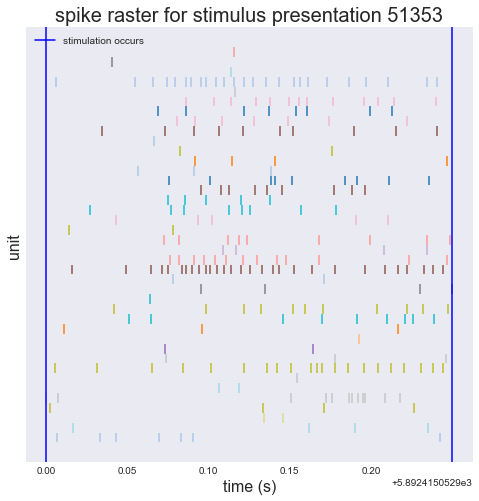

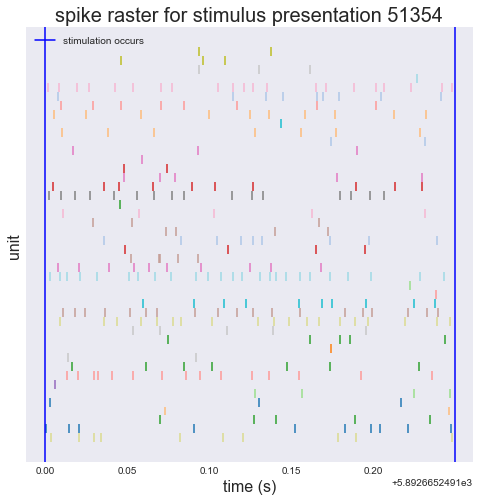

In [25]:
from allensdk.brain_observatory.ecephys.visualization import raster_plot
# first_id = spike_times['stimulus_presentation_id'][0]
first_id = 51353
second_id = 51354

plot_times = spike_times[spike_times['stimulus_presentation_id'] == first_id]
fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_id}')
plt.axvline(presentations.loc[first_id].start_time, label="stimulation occurs", color='b')
plt.axvline(presentations.loc[first_id].start_time + 0.25, color='b')
xticks = np.arange(presentations.loc[first_id].start_time, presentations.loc[first_id].start_time + 0.25, 0.05)
plt.xticks(xticks)
ax1 = fig.axes[0]
myyfmt = ScalarFormatter(useOffset=True)
myyfmt.set_useOffset(presentations.loc[first_id].start_time)
ax1.xaxis.set_major_formatter(myyfmt)
plt.legend(loc = 'upper left')

# # #

plot_times = spike_times[spike_times['stimulus_presentation_id'] == second_id]
fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {second_id}')
plt.axvline(presentations.loc[second_id].start_time, label="stimulation occurs", color='b')
plt.axvline(presentations.loc[second_id].start_time + 0.25, color='b')
xticks = np.arange(presentations.loc[second_id].start_time, presentations.loc[second_id].start_time + 0.25, 0.05)
plt.xticks(xticks)
ax2 = fig.axes[0]
myyfmt = ScalarFormatter(useOffset=True)
myyfmt.set_useOffset(presentations.loc[second_id].start_time)
ax2.xaxis.set_major_formatter(myyfmt)
plt.legend(loc = 'upper left')
plt.legend(loc = 'upper left')


plt.show()



In [7]:
with open("all_data", "rb") as f:
    my_data = pickle.load(f)
my_data

{721123822: (                          frame   start_time stimulus_block   stimulus_name  \
  stimulus_presentation_id                                                      
  66511                       0.0  8135.523905           13.0  natural_scenes   
  66122                       0.0  8038.192664           13.0  natural_scenes   
  51994                       0.0  6065.512089            9.0  natural_scenes   
  51861                       0.0  6032.234288            9.0  natural_scenes   
  52716                       0.0  6246.162932            9.0  natural_scenes   
  ...                         ...          ...            ...             ...   
  67245                     117.0  8319.177312           13.0  natural_scenes   
  52893                     117.0  6290.449908            9.0  natural_scenes   
  66357                     117.0  8096.991752           13.0  natural_scenes   
  67666                     117.0  8424.515222           13.0  natural_scenes   
  53967          

In [5]:
# Save all the units and presentations information
session_per_chunk = 5
num_workers = (len(sessions.index) - 1) // session_per_chunk + 1 # should be 6

def get_data_worker(rank):
    start = rank * session_per_chunk
    stop = (rank + 1) * session_per_chunk
    all_data = {}
    for id in sessions.index[start:stop]:
        session = cache.get_session_data(id)
        print(f"Get session {id}")
        presentations = session.get_stimulus_table("natural_scenes")
        print("presentations", len(presentations))
        units = session.units
        print("units", len(units))
        all_data[id] = (presentations, units)

    import pickle
    with open(f"ephsy_natural_scenes_presentation_{rank}_{num_workers}.pkl", "wb") as f:
        pickle.dump(all_data, f, pickle.HIGHEST_PROTOCOL)

process_pool = []

for i in range(0, num_workers):
    print(i)
    get_data_worker(i)
#     p = threading.Thread(target=get_data_worker, args=(i,))
#     process_pool.append(p)
#     p.start()
# for p in process_pool:
#     p.join()


8
Get session 789848216
presentations 0
units 415
Get session 791319847
presentations 5950
units 555


Downloading: 100%|██████████| 2.69G/2.69G [36:56<00:00, 1.21MB/s]   


Get session 793224716
presentations 0
units 781
Get session 794812542
presentations 0
units 1005
Get session 797828357
presentations 5950
units 611
9
Get session 798911424
presentations 5950
units 825
Get session 799864342
presentations 5950
units 604
Get session 816200189
presentations 0
units 634
Get session 819186360
presentations 0
units 531
Get session 819701982
presentations 0
units 585
10
Get session 821695405
presentations 0
units 474
Get session 829720705
presentations 0
units 529
Get session 831882777
presentations 0
units 657
Get session 835479236
presentations 0
units 582
Get session 839068429
presentations 0
units 742
11
Get session 839557629
presentations 0
units 450
Get session 840012044
presentations 0
units 758
Get session 847657808
presentations 0
units 874


In [12]:
# Load cached data. all_data: {id -> (presentations, units)}

all_presentations_units_dict = {}
for filename in os.listdir():
    match = re.match(r"ephsy_natural_scenes_presentation_(\d+)_(\d+).pkl", filename)
    if match is None:
        continue
    with open(filename, "rb") as f:
        this_data = pickle.load(f)
        all_presentations_units_dict = {**all_presentations_units_dict, **this_data}
print(all_presentations_units_dict.keys(), len(all_presentations_units_dict))

dict_keys([715093703, 719161530, 721123822, 732592105, 737581020, 821695405, 829720705, 831882777, 835479236, 839068429, 839557629, 840012044, 847657808, 739448407, 742951821, 743475441, 744228101, 746083955, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 756029989, 757216464, 757970808, 758798717, 759883607, 760345702, 760693773, 761418226, 762120172, 762602078, 763673393, 766640955, 767871931, 768515987, 771160300, 771990200, 773418906, 774875821, 778240327, 778998620, 779839471, 781842082, 786091066, 787025148, 789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 819186360, 819701982]) 58


In [13]:
regions = ["VISp", "VISal", "VISam", "VISl", "VISpm", "VISrl"]

for id in sessions.index[9:]:
    id_dir = f".\\ephys_spike_count\\{id}"
    print(id_dir)
    try:
        os.mkdir(id_dir)
    except FileExistsError:
        pass
    session = cache.get_session_data(id)
    print(f"Load session {id} complete")
    
    filename = "presentation_unit.pkl"
    pupath = os.path.join(id_dir, filename)
    presentations, units = None, None
    if os.path.exists(pupath):
        print("Presentation cache path exists")
        with open(pupath, "rb") as f:
            presentations, units = pickle.load(f)
    else:
        # load presentations and units, and dump
        if id in all_presentations_units_dict.keys():
            presentations, units = all_presentations_units_dict[id]
        else:
            presentations = session.get_stimulus_table("natural_scenes")
            units = session.units
        with open(pupath, "wb") as f:
            pickle.dump((presentations, units), f, pickle.HIGHEST_PROTOCOL)
    print("presentations", len(presentations))
    if (len(presentations) != 5900):
        print(f"session {id} has irregular stimulus, you should deal with it manually later")
    print("units", len(units))
    #     # continue
    # Save raw data
    # presentations = presentations[presentations['frame'] != -1]
    # presentations = presentations.sort_values('frame') # from 0 to 117
    for region in regions:
        region_units = units[units['ecephys_structure_acronym'] == region]
        if len(region_units) == 0:
            continue
        print(f"id={id}, region={region}")
        data_filepath = f"ephys_{region}.pkl"
        fullpath = os.path.join(id_dir, data_filepath)
        if os.path.exists(fullpath):
            print(f"{fullpath} already exists, skipping")
            continue
        spike_count = get_spike_count(session, region_units, 
        )
        with open(fullpath, "wb") as f:
            pickle.dump(spike_count, f, pickle.HIGHEST_PROTOCOL)
# import pickle
# for region, arr in total_data_in_regions.items():
#     if type(arr) == type(None):
#         continue
    # session_id = 715093703
    # session = cache.get_session_data(session_id)

.\ephys_spike_count\746083955
Load session 746083955 complete
Presentation cache path exists
presentations 5950
session 746083955 has irregular stimulus, you should deal with it manually later
units 582
id=746083955, region=VISp
.\ephys_spike_count\746083955\ephys_VISp.pkl already exists, skipping
id=746083955, region=VISal
.\ephys_spike_count\746083955\ephys_VISal.pkl already exists, skipping
id=746083955, region=VISl
.\ephys_spike_count\746083955\ephys_VISl.pkl already exists, skipping
id=746083955, region=VISpm
.\ephys_spike_count\746083955\ephys_VISpm.pkl already exists, skipping
id=746083955, region=VISrl
.\ephys_spike_count\746083955\ephys_VISrl.pkl already exists, skipping
.\ephys_spike_count\750332458
Load session 750332458 complete
presentations 5950
session 750332458 has irregular stimulus, you should deal with it manually later
units 902
id=750332458, region=VISp
id=750332458, region=VISal
id=750332458, region=VISam
id=750332458, region=VISl
id=750332458, region=VISpm
id=750

c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


id=756029989, region=VISal
id=756029989, region=VISam
id=756029989, region=VISl
id=756029989, region=VISpm
id=756029989, region=VISrl
.\ephys_spike_count\757216464
Load session 757216464 complete
presentations 5950
session 757216464 has irregular stimulus, you should deal with it manually later
units 959
id=757216464, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


id=757216464, region=VISal
id=757216464, region=VISam
id=757216464, region=VISl
id=757216464, region=VISrl
.\ephys_spike_count\757970808
Load session 757970808 complete
presentations 5950
session 757970808 has irregular stimulus, you should deal with it manually later
units 773
id=757970808, region=VISp
id=757970808, region=VISal
id=757970808, region=VISam
id=757970808, region=VISrl
.\ephys_spike_count\758798717
Load session 758798717 complete
presentations 5950
session 758798717 has irregular stimulus, you should deal with it manually later
units 593
id=758798717, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


id=758798717, region=VISal
id=758798717, region=VISam
id=758798717, region=VISpm
.\ephys_spike_count\759883607
Load session 759883607 complete
presentations 5950
session 759883607 has irregular stimulus, you should deal with it manually later
units 483
id=759883607, region=VISp
id=759883607, region=VISal
id=759883607, region=VISam
id=759883607, region=VISpm
.\ephys_spike_count\760345702
Load session 760345702 complete
presentations 5950
session 760345702 has irregular stimulus, you should deal with it manually later
units 501
id=760345702, region=VISp
id=760345702, region=VISal
id=760345702, region=VISam
id=760345702, region=VISl
id=760345702, region=VISpm
.\ephys_spike_count\760693773
Load session 760693773 complete
presentations 5950
session 760693773 has irregular stimulus, you should deal with it manually later
units 826
id=760693773, region=VISp
id=760693773, region=VISal
id=760693773, region=VISam
id=760693773, region=VISpm
id=760693773, region=VISrl
.\ephys_spike_count\761418226

c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=766640955, region=VISal
id=766640955, region=VISam
id=766640955, region=VISl
id=766640955, region=VISrl
.\ephys_spike_count\767871931
Load session 767871931 complete
presentations 0
session 767871931 has irregular stimulus, you should deal with it manually later
units 713
id=767871931, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=767871931, region=VISal
id=767871931, region=VISam
id=767871931, region=VISpm
id=767871931, region=VISrl
.\ephys_spike_count\768515987
Load session 768515987 complete
presentations 0
session 768515987 has irregular stimulus, you should deal with it manually later
units 802
id=768515987, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=768515987, region=VISal
id=768515987, region=VISam
id=768515987, region=VISl
id=768515987, region=VISrl
.\ephys_spike_count\771160300
Load session 771160300 complete
presentations 0
session 771160300 has irregular stimulus, you should deal with it manually later
units 930
id=771160300, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=771160300, region=VISal
id=771160300, region=VISam
id=771160300, region=VISpm
.\ephys_spike_count\771990200
Load session 771990200 complete
presentations 0
session 771990200 has irregular stimulus, you should deal with it manually later
units 546
id=771990200, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')
c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


id=771990200, region=VISal
id=771990200, region=VISam
id=771990200, region=VISpm
id=771990200, region=VISrl
.\ephys_spike_count\773418906
Load session 773418906 complete
presentations 5950
session 773418906 has irregular stimulus, you should deal with it manually later
units 546
id=773418906, region=VISp
id=773418906, region=VISal
id=773418906, region=VISam
id=773418906, region=VISrl
.\ephys_spike_count\774875821
Load session 774875821 complete
presentations 0
session 774875821 has irregular stimulus, you should deal with it manually later
units 649
id=774875821, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=774875821, region=VISal
id=774875821, region=VISam
id=774875821, region=VISl
id=774875821, region=VISrl
.\ephys_spike_count\778240327
Load session 778240327 complete
presentations 0
session 778240327 has irregular stimulus, you should deal with it manually later
units 784
id=778240327, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=778240327, region=VISal
id=778240327, region=VISam
id=778240327, region=VISl
id=778240327, region=VISpm
id=778240327, region=VISrl
.\ephys_spike_count\778998620
Load session 778998620 complete
presentations 0
session 778998620 has irregular stimulus, you should deal with it manually later
units 793
id=778998620, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=778998620, region=VISal
id=778998620, region=VISam
id=778998620, region=VISl
id=778998620, region=VISpm
id=778998620, region=VISrl
.\ephys_spike_count\779839471
Load session 779839471 complete
presentations 0
session 779839471 has irregular stimulus, you should deal with it manually later
units 863
id=779839471, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=779839471, region=VISam
id=779839471, region=VISpm
id=779839471, region=VISrl
.\ephys_spike_count\781842082
Load session 781842082 complete
presentations 0
session 781842082 has irregular stimulus, you should deal with it manually later
units 833
id=781842082, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=781842082, region=VISal
id=781842082, region=VISam
id=781842082, region=VISrl
.\ephys_spike_count\786091066
Load session 786091066 complete
presentations 0
session 786091066 has irregular stimulus, you should deal with it manually later
units 700
id=786091066, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=786091066, region=VISal
id=786091066, region=VISam
id=786091066, region=VISpm
id=786091066, region=VISrl
.\ephys_spike_count\787025148
Load session 787025148 complete
presentations 0
session 787025148 has irregular stimulus, you should deal with it manually later
units 696
id=787025148, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=787025148, region=VISal
id=787025148, region=VISam
id=787025148, region=VISrl
.\ephys_spike_count\789848216
Load session 789848216 complete
presentations 0
session 789848216 has irregular stimulus, you should deal with it manually later
units 415
id=789848216, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=789848216, region=VISal
id=789848216, region=VISam
id=789848216, region=VISl
id=789848216, region=VISrl
.\ephys_spike_count\791319847
Load session 791319847 complete
presentations 5950
session 791319847 has irregular stimulus, you should deal with it manually later
units 555
id=791319847, region=VISp
id=791319847, region=VISal
id=791319847, region=VISam
id=791319847, region=VISl
id=791319847, region=VISpm
id=791319847, region=VISrl
.\ephys_spike_count\793224716
Load session 793224716 complete
presentations 0
session 793224716 has irregular stimulus, you should deal with it manually later
units 781
id=793224716, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=793224716, region=VISal
id=793224716, region=VISrl
.\ephys_spike_count\794812542
Load session 794812542 complete
presentations 0
session 794812542 has irregular stimulus, you should deal with it manually later
units 1005
id=794812542, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=794812542, region=VISal
id=794812542, region=VISam
id=794812542, region=VISl
id=794812542, region=VISpm
id=794812542, region=VISrl
.\ephys_spike_count\797828357
Load session 797828357 complete
presentations 5950
session 797828357 has irregular stimulus, you should deal with it manually later
units 611
id=797828357, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


id=797828357, region=VISal
id=797828357, region=VISam
id=797828357, region=VISl
id=797828357, region=VISpm
id=797828357, region=VISrl
.\ephys_spike_count\798911424
Load session 798911424 complete
presentations 5950
session 798911424 has irregular stimulus, you should deal with it manually later
units 825
id=798911424, region=VISp
id=798911424, region=VISal
id=798911424, region=VISam
id=798911424, region=VISl
id=798911424, region=VISrl
.\ephys_spike_count\799864342
Load session 799864342 complete
presentations 5950
session 799864342 has irregular stimulus, you should deal with it manually later
units 604
id=799864342, region=VISp
id=799864342, region=VISal
id=799864342, region=VISam
id=799864342, region=VISl
id=799864342, region=VISrl
.\ephys_spike_count\816200189
Load session 816200189 complete
presentations 0
session 816200189 has irregular stimulus, you should deal with it manually later
units 634
id=816200189, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=816200189, region=VISam
id=816200189, region=VISl
id=816200189, region=VISpm
.\ephys_spike_count\819186360
Load session 819186360 complete
presentations 0
session 819186360 has irregular stimulus, you should deal with it manually later
units 531
id=819186360, region=VISam


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=819186360, region=VISl
id=819186360, region=VISpm
id=819186360, region=VISrl
.\ephys_spike_count\819701982
Load session 819701982 complete
presentations 0
session 819701982 has irregular stimulus, you should deal with it manually later
units 585
id=819701982, region=VISam


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=819701982, region=VISl
id=819701982, region=VISrl
.\ephys_spike_count\821695405
Load session 821695405 complete
presentations 0
session 821695405 has irregular stimulus, you should deal with it manually later
units 474
id=821695405, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=821695405, region=VISal
id=821695405, region=VISam
id=821695405, region=VISl
id=821695405, region=VISpm
.\ephys_spike_count\829720705
Load session 829720705 complete
presentations 0
session 829720705 has irregular stimulus, you should deal with it manually later
units 529
id=829720705, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=829720705, region=VISal
id=829720705, region=VISam
id=829720705, region=VISl
id=829720705, region=VISrl
.\ephys_spike_count\831882777
Load session 831882777 complete
presentations 0
session 831882777 has irregular stimulus, you should deal with it manually later
units 657
id=831882777, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=831882777, region=VISal
id=831882777, region=VISam
id=831882777, region=VISl
id=831882777, region=VISpm
id=831882777, region=VISrl
.\ephys_spike_count\835479236
Load session 835479236 complete
presentations 0
session 835479236 has irregular stimulus, you should deal with it manually later
units 582
id=835479236, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=835479236, region=VISal
id=835479236, region=VISl
id=835479236, region=VISrl
.\ephys_spike_count\839068429
Load session 839068429 complete
presentations 0
session 839068429 has irregular stimulus, you should deal with it manually later
units 742
id=839068429, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=839068429, region=VISam
id=839068429, region=VISl
id=839068429, region=VISpm
id=839068429, region=VISrl
.\ephys_spike_count\839557629
Load session 839557629 complete
presentations 0
session 839557629 has irregular stimulus, you should deal with it manually later
units 450
id=839557629, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')


id=839557629, region=VISal
id=839557629, region=VISam
id=839557629, region=VISl
id=839557629, region=VISpm
.\ephys_spike_count\840012044
Load session 840012044 complete
presentations 0
session 840012044 has irregular stimulus, you should deal with it manually later
units 758
id=840012044, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')
c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


id=840012044, region=VISam
id=840012044, region=VISl
id=840012044, region=VISpm
id=840012044, region=VISrl
.\ephys_spike_count\847657808
Load session 847657808 complete
presentations 0
session 847657808 has irregular stimulus, you should deal with it manually later
units 874
id=847657808, region=VISp


c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1311: UserWarning: filtering to an empty set of stimulus_presentations!
  warnings.warn(f'filtering to an empty set of {key}!')
c:\Users\bj\miniconda3\envs\allen\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


id=847657808, region=VISal
id=847657808, region=VISam
id=847657808, region=VISl
id=847657808, region=VISpm
id=847657808, region=VISrl


In [25]:
import xarray as xr
regions = ["VISp", "VISal", "VISam", "VISl", "VISpm", "VISrl"]
total_data_in_regions = {region:None for region in regions}

for id in sessions.index[21:30]:
    session = cache.get_session_data(id)
    print("Get session")
    presentations = session.get_stimulus_table("natural_scenes")
    presentations = presentations[presentations['frame'] != -1]
    presentations = presentations.sort_values('frame') # from 0 to 117
    print("presentations", len(presentations))
    units = session.units
    print("units", len(units))
    for region in regions:
        units = units[units['ecephys_structure_acronym'] == region]
        if len(units) == 0:
            continue
        print(f"id={id}, region={region}")
        spike_count = get_spike_count(units, presentations)
        if type(total_data_in_regions[region]) == type(None):
            total_data_in_regions[region] = spike_count
        else:
            total_data_in_regions[region] = xr.concat([total_data_in_regions[region], spike_count], dim='unit_id')
        print(total_data_in_regions[region].shape)
import pickle
for region, arr in total_data_in_regions.items():
    if type(arr) == type(None):
        continue
    with open(f"ephsy_{region}_{2}.pkl", "wb") as f:
        pickle.dump(arr, f, pickle.HIGHEST_PROTOCOL)
    # session_id = 715093703
    # session = cache.get_session_data(session_id)

Get session


TypeError: Cannot use .str.match with values of inferred dtype 'bytes'.

In [20]:
with open("ephsy_VISp_0.pkl", "rb") as f:
    data = pickle.load(f)
data.shape

(5954, 26, 303)

In [28]:
regions = ["VISp", "VISal", "VISam", "VISl", "VISpm", "VISrl"]
total_data_in_regions = {region:None for region in regions}
for region in regions:
    for id in sessions.index:
        id_dir = f".\\ephys_spike_count\\{id}"
        print(id_dir)
        try:
            os.mkdir(id_dir)
        except FileExistsError:
            pass
        print(f"Get session print(id={id}, region={region}")
        presentations, units = all_presentations_units_dict[id]
        if len(units) == 0 or len(presentations) == 0:
            continue
        sorted_presentations = presentations[presentations['frame'] != -1].sort_values('frame')
        sorted_presentation_ids = sorted_presentations.index
        units = units[units['ecephys_structure_acronym'] == region]
        data_filepath = os.path.join(id_dir, f"ephys_{region}.pkl")
        if not os.path.exists(data_filepath):
            continue
        with open(data_filepath, "rb") as f:
            data = pickle.load(f)
        sorted_data = data.loc[sorted_presentation_ids, :, :]
        sorted_data = sorted_data.drop("stimulus_presentation_id")
        if sorted_data.shape[0] != 5900:
            print("id, sort data size not correct")
            continue # FIXME
        if type(total_data_in_regions[region]) == type(None):
            total_data_in_regions[region] = sorted_data
        else:
            print(total_data_in_regions[region].shape, sorted_data.shape)
            total_data_in_regions[region] = xr.concat([total_data_in_regions[region], sorted_data], dim='unit_id')
        print(total_data_in_regions[region].shape)
        # if type(total_data_in_regions[region]) == type(None):
        #     total_data_in_regions[region] = spike_count
        # else:
        #     total_data_in_regions[region] = xr.concat([total_data_in_regions[region], spike_count], dim='unit_id')
        # print(total_data_in_regions[region].shape)

.\ephys_spike_count\715093703
Get session print(id=715093703, region=VISp
(5900, 26, 60)
.\ephys_spike_count\719161530
Get session print(id=719161530, region=VISp
(5900, 26, 60) (5900, 26, 52)
(5900, 26, 112)
.\ephys_spike_count\721123822
Get session print(id=721123822, region=VISp
(5900, 26, 112) (5900, 26, 41)
(5900, 26, 153)
.\ephys_spike_count\732592105
Get session print(id=732592105, region=VISp
(5900, 26, 153) (5900, 26, 110)
(5900, 26, 263)
.\ephys_spike_count\737581020
Get session print(id=737581020, region=VISp
id, sort data size not correct
.\ephys_spike_count\739448407
Get session print(id=739448407, region=VISp
(5900, 26, 263) (5900, 26, 19)
(5900, 26, 282)
.\ephys_spike_count\742951821
Get session print(id=742951821, region=VISp
(5900, 26, 282) (5900, 26, 33)
(5900, 26, 315)
.\ephys_spike_count\743475441
Get session print(id=743475441, region=VISp
(5900, 26, 315) (5900, 26, 45)
(5900, 26, 360)
.\ephys_spike_count\744228101
Get session print(id=744228101, region=VISp
(5900,

In [29]:
total_data_in_regions

{'VISp': <xarray.DataArray 'spike_counts' (stimulus_presentation_id: 5900, time_relative_to_stimulus_onset: 26, unit_id: 1975)>
 array([[[0, 0, 0, ..., 0, 0, 0],
         [1, 0, 1, ..., 2, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 1, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 1, 1, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 1, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 1, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 1, 0, ..., 0, 1, 0],
         [2, 1, 0, ..., 1, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 1, 1, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 1],
         [0, 2, 0, ..., 0, 0, 0],
         ...,
         [1, 1, 0, ..., 1, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [

In [30]:
for region, arr in total_data_in_regions.items():
    if type(arr) == type(None):
        continue
    with open(f"ephys_natural_scene_spike_count_{region}.pkl", "wb") as f:
        pickle.dump(arr, f, pickle.HIGHEST_PROTOCOL)

In [23]:
total_data_in_regions["VISp"].drop("stimulus_presentation_id")

AttributeError: 'NoneType' object has no attribute 'drop'

## Training

In [25]:
import re
regions = ["VISp", "VISal", "VISam", "VISl", "VISpm", "VISrl"]
total_data_in_regions = {region:None for region in regions}

for folder_name in os.listdir("."):
    match = re.match(r"ephsy_(\d+)_spike_count", folder_name)
    if (match == None):
        continue
    # get each
    exp_id = int(match.groups()[0])
    # print(folder_name, exp_id)
    pudata_file = os.path.join(folder_name, "presentation_unit.pkl")
    with open(pudata_file, "rb") as f:
        presentations, units = pickle.load(f)
    sorted_presentations = presentations[presentations['frame'] != -1].sort_values('frame')
    sorted_presentation_ids = sorted_presentations.index
    # print(sorted_presentations)
    for region in regions:
        data_filepath = os.path.join(folder_name, f"ephsy_{region}.pkl")
        if not os.path.exists(data_filepath):
            continue
        with open(data_filepath, "rb") as f:
            data = pickle.load(f)
        # print(region, data.shape)
        # TODO: temporarily filted implemented data
        sorted_data = data.loc[sorted_presentation_ids, :, :]
        sorted_data = sorted_data.drop("stimulus_presentation_id")
        if sorted_data.shape[0] != 5900:
            continue # FIXME
        if type(total_data_in_regions[region]) == type(None):
            total_data_in_regions[region] = sorted_data
        else:
            print(total_data_in_regions[region].shape, sorted_data.shape)
            total_data_in_regions[region] = xr.concat([total_data_in_regions[region], sorted_data], dim='unit_id')
        print(total_data_in_regions[region].shape)
        # print(sorted_data.shape)


In [3]:
from sklearn.model_selection import train_test_split
def get_data_from_region(region):
    X = total_data_in_regions[region].data.reshape(5900, -1).astype(np.float32)
    y = np.repeat(np.arange(0, 118), 50)
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)
    print("Training size:", X_train.shape, y_train.shape)
    print("Test size:", X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

def get_data_from_region_by_frame(region, frame = 0):
    X = total_data_in_regions[region].data[:, frame, :].reshape(5900, -1).astype(np.float32)
    y = np.repeat(np.arange(0, 118), 50)
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)
    print("Training size:", X_train.shape, y_train.shape)
    print("Test size:", X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [5]:
# X_train, X_test, y_train, y_test =  get_data_from_region("VISp")
X_train, X_test, y_train, y_test =  get_data_from_region_by_frame("VISp", frame = 2)


Training size: (4720, 409) (4720,)
Test size: (1180, 409) (1180,)


## Training


In [4]:
# My GPU has only 4G device memory, not enough for DNN. Disable GPU here
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.callbacks import CSVLogger

In [5]:
def create_snn():
    model = models.Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(400,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(118))
    model.add(layers.Softmax())
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [6]:
def create_dnn():
    model = models.Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(400,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(400,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(118))
    model.add(layers.Softmax())
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [7]:
def create_cnn():
    model = models.Sequential()
    model.add(layers.Reshape((-1, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(32, 3)) # TODO: filter = ? kernel = ?
    model.add(layers.MaxPool1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(400,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(118))
    model.add(layers.Softmax())
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [8]:
import os
model_dump_path = ".\\ephsy_model"
try:
    os.mkdir(model_dump_path)
except FileExistsError:
    pass

_epoch = 20
def single_run(model: models.Sequential, case_name, dataset, type="tf", save_model = True):
    '''
    model: the model
    case_name: the case tag, and everything will be saved to .\\model\\{case_name}
    dataset: the data, X_train, X_test, y_train, y_test
    type: 'sklearn': SVM, 'tf': SNN/DNN/CNN
    '''
    model_dump_fullpath = os.path.join(model_dump_path, case_name)
    print(model_dump_fullpath)
    try:
        os.mkdir(model_dump_fullpath)
    except FileExistsError:
        pass
    # read data file
    X_train, X_test, y_train, y_test = dataset
    print("Training size:", X_train.shape, y_train.shape)
    print("Test size:", X_test.shape, y_test.shape)

    if type == "tf":
        # save history
        csv_logger = CSVLogger(os.path.join(model_dump_fullpath, 'training.log'))
        
        history = model.fit(X_train, y_train, epochs=_epoch, verbose = 0,
                        validation_data=(X_test, y_test), callbacks=[csv_logger])
        # history_dump_file = os.path.join(model_dump_fullpath, "history.csv")
        # df_history = pd.DataFrame(history.history)
        # df_history.to_csv(history_dump_file)
        # save model
        if save_model:
            model.save(model_dump_fullpath)
    elif type == "sklearn":
        model.fit(X_train, y_train)
        pred_acc = model.score(X_test, y_test)
        with open(os.path.join(model_dump_fullpath, "score.log"), "w") as f: 
            f.write(f"{pred_acc}" + "\n")

In [9]:
for frame in range(26):
    for region in regions:
        data = get_data_from_region_by_frame(region, frame)
        # (X_train, X_test, y_train, y_test) = data

        # model = create_snn()
        # case_name = f"{region}_0_frame{frame}_SNN"
        # single_run(model, case_name, data, save_model = False)

        # model = create_dnn()
        # case_name = f"{region}_0_frame{frame}_DNN"
        # single_run(model, case_name, data, save_model = False)

        model = create_cnn()
        case_name = f"{region}_0_frame{frame}_CNN"
        single_run(model, case_name, data, save_model = False)


Training size: (4720, 409) (4720,)
Test size: (1180, 409) (1180,)
.\ephsy_model\VISp_0_frame0_CNN
Training size: (4720, 409) (4720,)
Test size: (1180, 409) (1180,)
Training size: (4720, 248) (4720,)
Test size: (1180, 248) (1180,)
.\ephsy_model\VISal_0_frame0_CNN
Training size: (4720, 248) (4720,)
Test size: (1180, 248) (1180,)
Training size: (4720, 215) (4720,)
Test size: (1180, 215) (1180,)
.\ephsy_model\VISam_0_frame0_CNN
Training size: (4720, 215) (4720,)
Test size: (1180, 215) (1180,)
Training size: (4720, 299) (4720,)
Test size: (1180, 299) (1180,)
.\ephsy_model\VISl_0_frame0_CNN
Training size: (4720, 299) (4720,)
Test size: (1180, 299) (1180,)
Training size: (4720, 272) (4720,)
Test size: (1180, 272) (1180,)
.\ephsy_model\VISpm_0_frame0_CNN
Training size: (4720, 272) (4720,)
Test size: (1180, 272) (1180,)
Training size: (4720, 474) (4720,)
Test size: (1180, 474) (1180,)
.\ephsy_model\VISrl_0_frame0_CNN
Training size: (4720, 474) (4720,)
Test size: (1180, 474) (1180,)
Training siz